In [1]:
import phoebe
from phoebe import u, c

import pandas as pd

import scienceplots
import matplotlib.pyplot as plt
plt.style.use("science")

import numpy as np
from astropy.table import Table

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[1].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
importlib.reload(gen_utils)

logger = phoebe.logger(clevel='WARNING')

# OBJ_DATA_DIR = "/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464"
# OBJ_DATA_DIR = "/home/ramon/uanl/Tesis/Backup Data"
OBJ_DATA_DIR = "/home/ramon/uanl/Tesis/Backup Data"
ZTF_DATA_DIR = os.path.join(OBJ_DATA_DIR, "IRSA")

# CONCAT_OBSERVATIONS_CSV = os.path.join(OBJ_DATA_DIR, "Iturbide", "normalized-phase-folded.csv")
CONCAT_OBSERVATIONS_CSV = os.path.join(OBJ_DATA_DIR, "Iturbide", "normalized-data.ecsv")

# AVILES_OBSERVATIONS_CSV = os.path.join(OBJ_DATA_DIR, "Iturbide Aviles", "aviles-differential-flux.csv")
AVILES_OBSERVATIONS_CSV = os.path.join(OBJ_DATA_DIR, "Iturbide Aviles", "normalized-differential-flux.ecsv")

# GAIA_EPOCH_PHOTOMETRY_CSV = f"{OBJ_DATA_DIR}/Gaia Epoch Photometry - Indiv/EPOCH_PHOTOMETRY-Gaia DR3 1982536257931470464.csv"
GAIA_EPOCH_PHOTOMETRY_CSV = os.path.join(OBJ_DATA_DIR, "Gaia Epoch Photometry - Indiv", "DR3", "rel-norm-flux.ecsv")

## Iturbide observation data

In [2]:
# iturbideObservations = pd.read_csv(CONCAT_OBSERVATIONS_CSV)
iturbideObservations = Table.read(CONCAT_OBSERVATIONS_CSV)
iturbideObservations

time,mag,err,raw_flux,ferr,obsv_date,julianDate,hjd,norm_flux,norm_ferr
Time,float64,float64,float64,float64,object,float64,Time,float64,float64
2022-10-22 03:54:21.841000,17.981,0.031,112240.92842194808,1092.3324438632785,2022-10-21,2459874.663553512,2022-10-22 03:59:25.480471,1.571809828203918,0.04487840090510403
2022-10-22 03:55:22.219000,18.061,0.027,105232.83011050562,880.8971288902421,2022-10-21,2459874.664252331,2022-10-22 04:00:25.856822,1.4601584968117884,0.03631110323220811
2022-10-22 03:56:22.714000,18.024,0.03,107386.88636453748,1014.6543851649874,2022-10-21,2459874.6649525044,2022-10-22 04:01:26.350168,1.5107757319249953,0.041744276150251954
2022-10-22 03:57:23.081000,17.929,0.021,116882.9731974464,781.5124606011574,2022-10-21,2459874.6656511966,2022-10-22 04:02:26.715518,1.6489215731508369,0.03189297076436863
2022-10-22 03:58:23.606000,18.002,0.02,109585.0349264616,707.3017352352562,2022-10-21,2459874.6663517174,2022-10-22 04:03:27.238863,1.5417004529495628,0.028399171846590653
2022-10-22 03:59:23.970000,17.988,0.024,111007.22608631152,837.9538608606848,2022-10-21,2459874.667050375,2022-10-22 04:04:27.601213,1.5617085932653765,0.034521282493954156
2022-10-22 04:00:24.671000,18.026,0.02,106108.76269690807,688.9434511375254,2022-10-21,2459874.6677529328,2022-10-22 04:05:28.300553,1.5079953418017917,0.027778300754698133
2022-10-22 04:01:25.043000,18.049,0.022,104076.15767275717,733.3202872846815,2022-10-21,2459874.6684516827,2022-10-22 04:06:28.670901,1.476386277753865,0.029915644304981746
2022-10-22 04:02:25.528000,18.006,0.021,109081.537426456,732.7290009403191,2022-10-21,2459874.6691517406,2022-10-22 04:07:29.154246,1.5360310683850291,0.029709474819688324


In [3]:
# avilesObservations = pd.read_csv(AVILES_OBSERVATIONS_CSV)
avilesObservations = Table.read(AVILES_OBSERVATIONS_CSV)
avilesObservations

time,mag,flux,norm_flux
Time,float64,float64,float64
2459875.574499226,17.04,91653.96349428449,0.8847080928705314
2459875.5751992064,17.123,84908.51597588573,0.8195963204818452
2459875.575899187,17.142,83435.57252792676,0.805378441199067
2459875.576599168,17.221,77580.26350777678,0.7488589075216437
2459875.5772991483,17.06,89981.09013014253,0.868560350348778
2459875.577999129,16.976,97219.02256440012,0.9384259312370187
2459875.578699109,16.979,96950.76725694016,0.9358365435835307
2459875.5793990903,17.087,87771.0412199913,0.8472274141405967
2459875.5800990704,17.286,73072.04309347547,0.705342414258096


## Gaia epoch photometry

In [14]:
from astropy.time import Time

# gaiaObservations = pd.read_csv(GAIA_EPOCH_PHOTOMETRY_CSV)
gaiaObservations = Table.read(GAIA_EPOCH_PHOTOMETRY_CSV)
gaiaObservations = gaiaObservations[(gaiaObservations['rejected_by_photometry'] == False) & (gaiaObservations['rejected_by_variability'] == False)]

# correcting units so that they're compatible with astropy
gaiaObservations['flux'] = gaiaObservations['flux'].value * u.electron*(u.second**(-1))
gaiaObservations['flux_error'] = gaiaObservations['flux_error'].value * u.electron*(u.second**(-1))

# using UTC scale for Gaia observations to be consistent with ZTF
t = Time(gaiaObservations['time'] + 2455197.5, format='jd', scale='tcb')
gaiaObservations['jdTime'] = t.utc.jd
gaiaObservations

source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id,norm_flux,norm_ferr,jdTime
,,,d,mag,electron / s,electron / s,,,,,,,,
int64,int64,str2,float64,float64,float64,float64,float32,bool,bool,int64,int64,float64,float64,float64
1982536257931470464,15914106402149388,G,1684.6450693283623,16.809997985690906,3555.8837344340627,13.240486584172205,268.5614,False,False,1,375316653866487564,1.657539938639094,0.006171921513562497,2456882.1440787413
1982536257931470464,15923847240881531,G,1684.8212356413167,16.808626557806893,3560.3781220208034,11.8728329238944,299.87604,False,False,1,375316653866487564,1.6596349528412202,0.005534403323025485,2456882.3202450518
1982536257931470464,15927939542726427,G,1684.895246305524,16.925121809057906,3198.144064473718,14.858678186406802,215.23746,False,False,1,375316653866487564,1.4907831392385014,0.006926225481124885,2456882.394255715
1982536257931470464,15937680367558820,G,1685.0714123177622,16.899170303743176,3275.507704711993,64.64265850452173,50.670994,False,False,4097,375316653866487564,1.5268454329101657,0.030132534192124232,2456882.5704217246
1982536257931470464,15941772663767622,G,1685.1453947312775,16.775474283211008,3670.7688153100084,13.205851380766035,277.96533,False,False,4194305,375316653866487564,1.7110924797589357,0.006155776656976578,2456882.644404137
1982536257931470464,15951513475367858,G,1685.321560485397,16.83977727503074,3459.6792498884624,7.291105011395783,474.50684,False,False,4194305,375316653866487564,1.6126951722407092,0.0033986762942134307,2456882.820569888
1982536257931470464,15955605767120211,G,1685.3955990426737,16.943218744401644,3145.2795341326964,16.929937606695407,185.7821,False,False,1,375316653866487564,1.4661408626845474,0.007891722518939954,2456882.8946084445
1982536257931470464,15965346564957887,G,1685.5717645182567,16.871210353436386,3360.954285937139,17.9847612619822,186.8779,False,False,1,375316653866487564,1.5666755093632665,0.008383418105026763,2456883.0707739173


In [15]:
gaia_g  = gaiaObservations[gaiaObservations['band'] == 'G']
gaia_bp = gaiaObservations[gaiaObservations['band'] == 'BP']
gaia_rp = gaiaObservations[gaiaObservations['band'] == 'RP']

## PHOEBE bundle set-up

In [8]:
b = phoebe.default_contact_binary()

In [9]:
computePhases = phoebe.linspace(0, 1, 16)
b.add_dataset('mesh', compute_times=b.to_time(computePhases), dataset='mesh01', columns=['teffs'], overwrite=True, ntriangles=5000)
print(b['mesh01'])

ParameterSet: 8 parameters
     compute_times@mesh01@dataset: [0.         0.03333333 0.06666667 ...
 0.43333333 0.46666667 0.5       ] d
C   compute_phases@mesh01@dataset: [ 0.          0.06666667  0.13333333 ...
 -0.13333333 -0.06666667  0.        ]
         phases_t0@mesh01@dataset: t0_supconj
     include_times@mesh01@dataset: []
       coordinates@mesh01@dataset: ['xyz', 'uvw']
           columns@mesh01@dataset: ['teffs']
         enabled@phoebe01@compute: True
        compute_phases@constraint: times_to_phases({compute_times@mesh01@dataset}, {phases_period@mesh01@dataset}, {period@binary@component}, {period_anom@binary@component}, {phases_dpdt@mesh01@dataset}, {dpdt@binary@component}, {phases_t0@mesh01@dataset}, {t0_supconj@binary@component}, {t0_perpass@binary@component}, {t0_ref@binary@component})


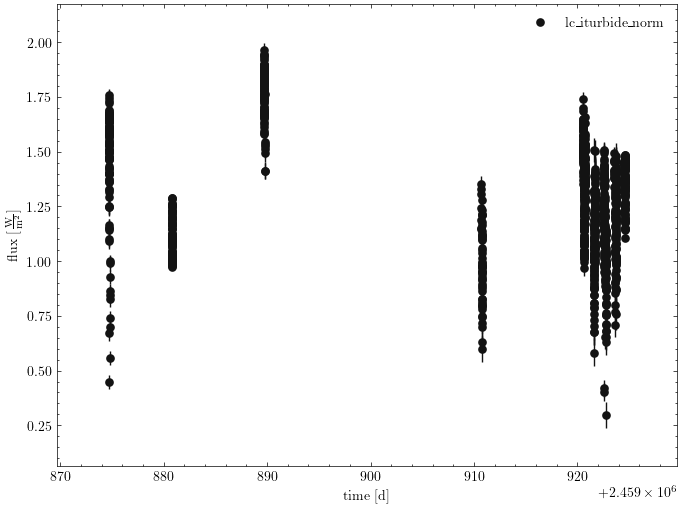

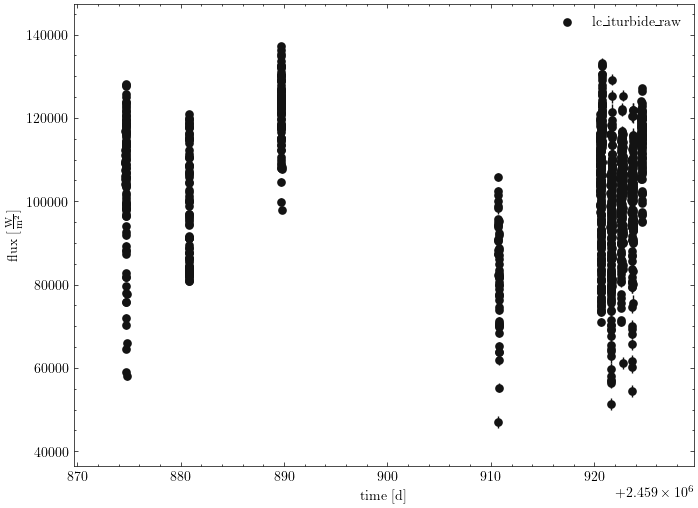

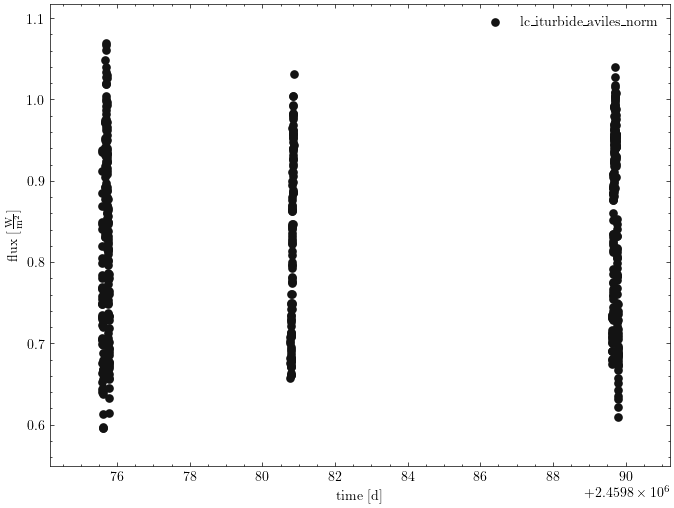

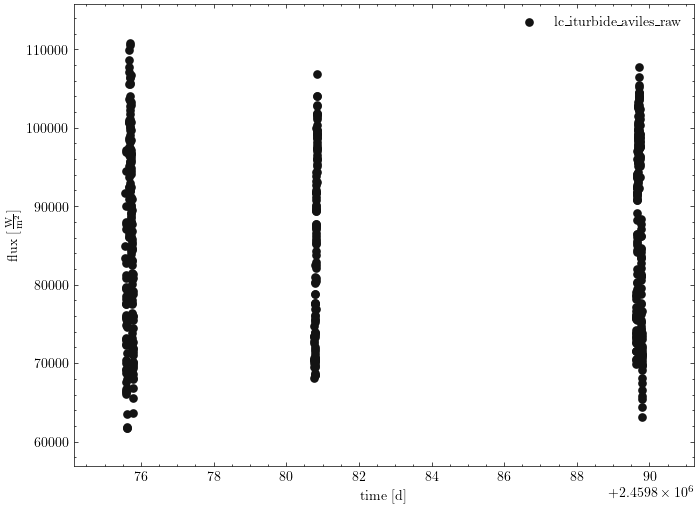

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [10]:
b.add_dataset('lc', dataset='lc_iturbide_norm', overwrite=True,
              times=iturbideObservations['hjd'].jd, 
              fluxes=iturbideObservations['norm_flux'], 
			  sigmas=iturbideObservations['norm_ferr'])
b.add_dataset('lc', dataset='lc_iturbide_raw', overwrite=True,
              times=iturbideObservations['hjd'].jd, 
              fluxes=iturbideObservations['raw_flux'], 
			  sigmas=iturbideObservations['ferr'])

b.add_dataset('lc', dataset='lc_iturbide_aviles_norm', overwrite=True,
              times=avilesObservations['time'].jd, 
              fluxes=avilesObservations['norm_flux'])
b.add_dataset('lc', dataset='lc_iturbide_aviles_raw', overwrite=True,
              times=avilesObservations['time'].jd, 
              fluxes=avilesObservations['flux'])

b.plot(dataset='lc_iturbide_norm', show=True, marker='.', legend=True)
b.plot(dataset='lc_iturbide_raw', show=True, marker='.', legend=True)

b.plot(dataset='lc_iturbide_aviles_norm', show=True, marker='.', legend=True)
b.plot(dataset='lc_iturbide_aviles_raw', show=True, marker='.', legend=True)

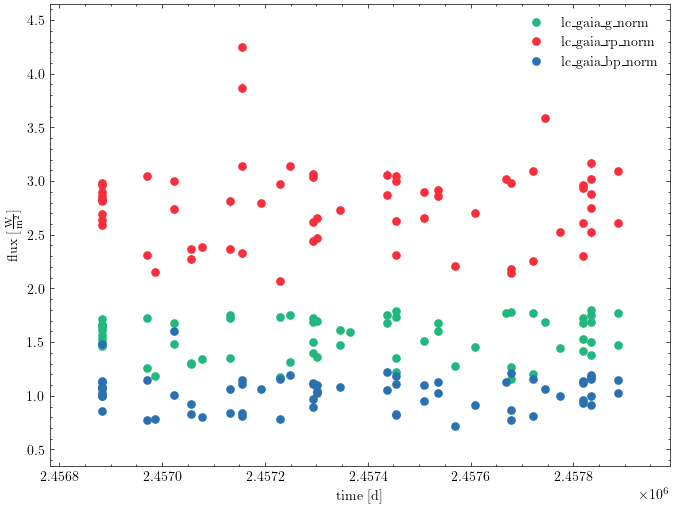

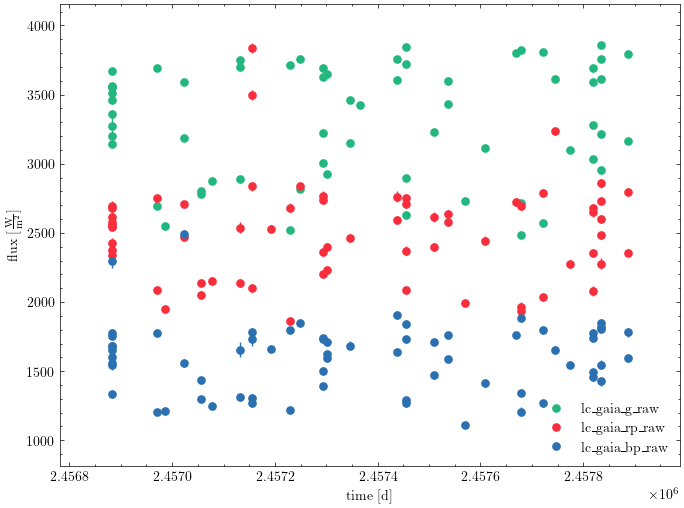

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [11]:
b.add_dataset('lc', 
              times=gaia_g['jdTime'], fluxes=gaia_g['norm_flux'], sigmas=gaia_g['norm_ferr'], 
              passband='Gaia:G', dataset='lc_gaia_g_norm', overwrite=True)
b.add_dataset('lc', 
              times=gaia_rp['jdTime'], fluxes=gaia_rp['norm_flux'], sigmas=gaia_rp['norm_ferr'], 
              passband='Gaia:RP', dataset='lc_gaia_rp_norm', overwrite=True)
b.add_dataset('lc', 
              times=gaia_bp['jdTime'], fluxes=gaia_bp['norm_flux'], sigmas=gaia_bp['norm_ferr'], 
              passband='Gaia:BP', dataset='lc_gaia_bp_norm', overwrite=True)

# TODO: try to figure out why units are messing up
    # electron/s from gaia, PHOEBE expects W/s
# ignoring units for now as work-around
b.add_dataset('lc', 
              times=gaia_g['jdTime'], fluxes=gaia_g['flux'].value, sigmas=gaia_g['flux_error'].value,
              passband='Gaia:G', dataset='lc_gaia_g_raw', overwrite=True)
b.add_dataset('lc', 
              times=gaia_rp['jdTime'], fluxes=gaia_rp['flux'].value, sigmas=gaia_rp['flux_error'].value,
              passband='Gaia:RP', dataset='lc_gaia_rp_raw', overwrite=True)
b.add_dataset('lc', 
              times=gaia_bp['jdTime'], fluxes=gaia_bp['flux'].value, sigmas=gaia_bp['flux_error'].value,
              passband='Gaia:BP', dataset='lc_gaia_bp_raw', overwrite=True)

b.plot(kind='lc', dataset=['lc_gaia_g_norm', 'lc_gaia_bp_norm', 'lc_gaia_rp_norm'], show=True, legend=True, marker='.', color=gen_utils.GAIA_NORM_PLOT_COLORS)
b.plot(kind='lc', dataset=['lc_gaia_g_raw', 'lc_gaia_bp_raw', 'lc_gaia_rp_raw'], show=True, legend=True, marker='.', color=gen_utils.GAIA_RAW_PLOT_COLORS)

## ZTF Data

Data retrieved using IRSA tools. Observations in `zg` and `zr` bands.

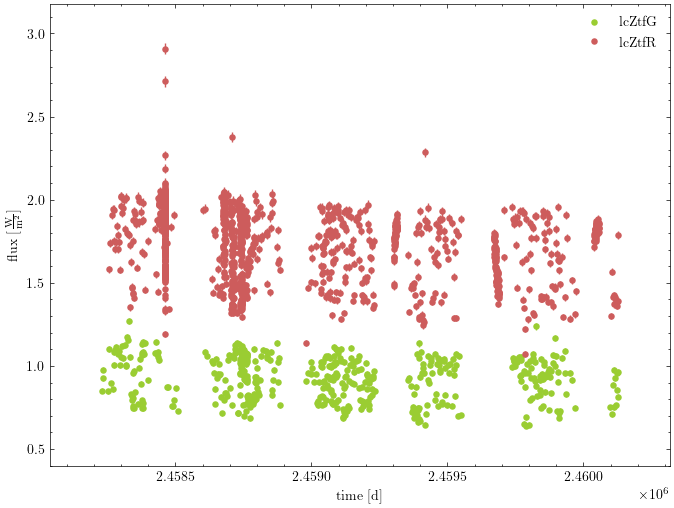

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [12]:
# for nameSuffix, passband, f in zip(["G", "R"], ["ZTF:g", "ZTF:r"], ["zg-flux.ecsv", "zr-flux.ecsv"]):
for nameSuffix, passband, f in zip(["G", "R"], ["ZTF:g", "ZTF:r"], ["rel-zg-flux.ecsv", "rel-zr-flux.ecsv"]):
	data = Table.read(os.path.join(ZTF_DATA_DIR, f))
	times = Time(data['hjd'], scale='utc', format='jd')
	b.add_dataset('lc', 
			   times=times.value, fluxes=data['flux'], sigmas=data['fluxerr'],
			   passband=passband, dataset=f'lcZtf{nameSuffix}', overwrite=True)
	
b.plot(dataset=['lcZtfG', 'lcZtfR'], marker='.', legend=True, color=gen_utils.ZTF_PLOT_COLORS, s=0.015, show=True)

## Orbital Period

Setting orbital period to that determined using IRSA periodogram; very slight difference to period obtained from PHOEBE periodogram, but results in noticably
better fit.

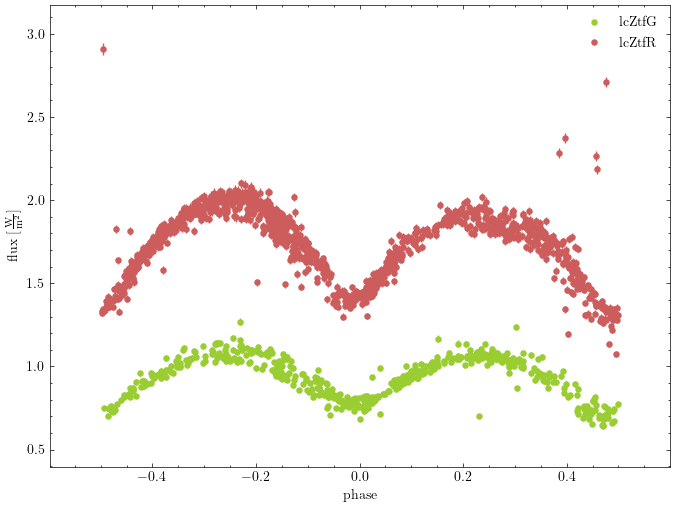

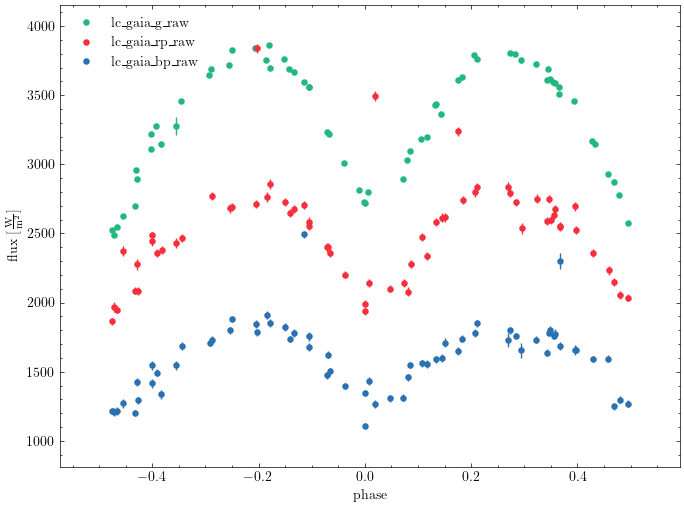

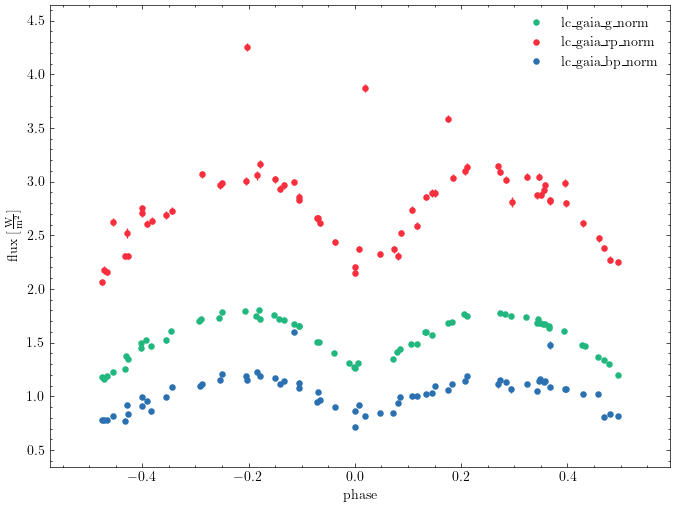

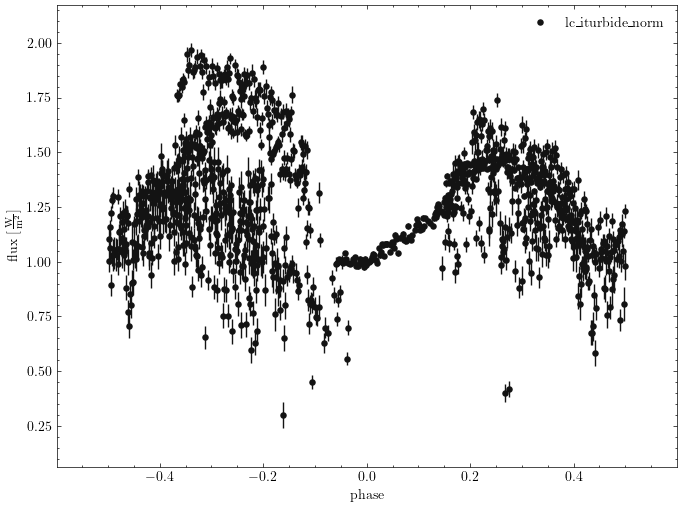

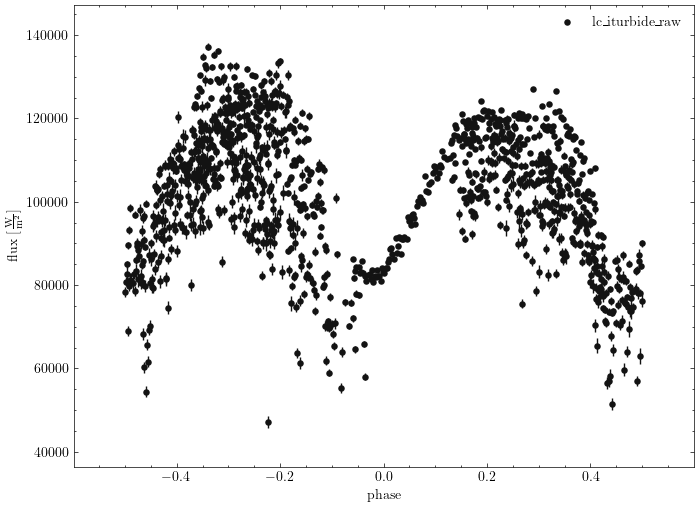

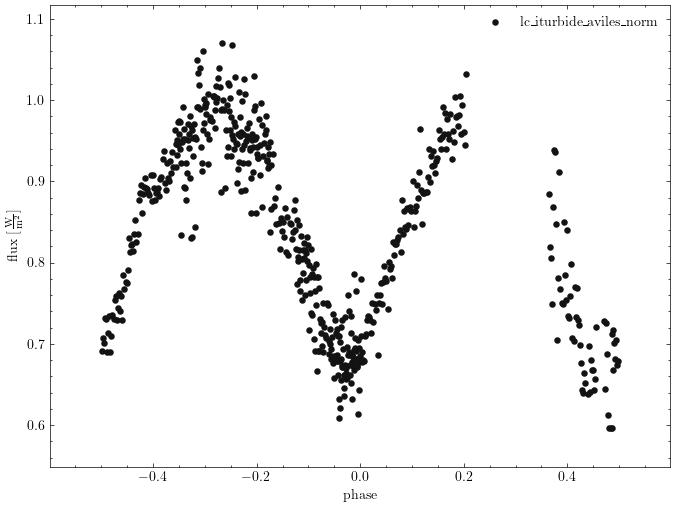

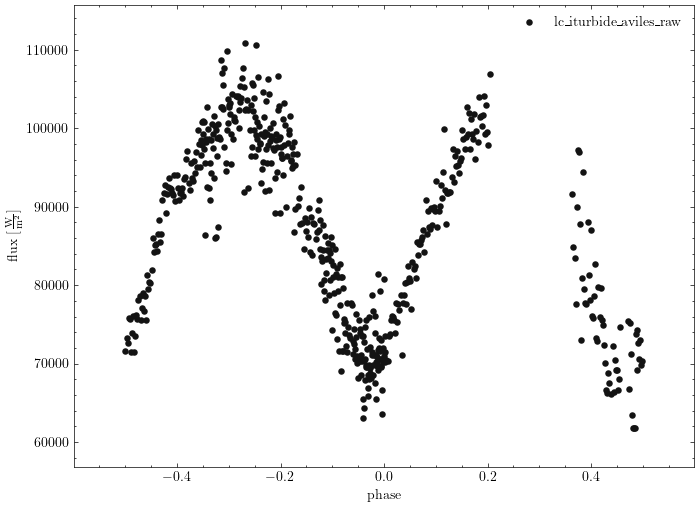

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [17]:
ZTF_PERIOD = 0.333566999 * u.day # obtained from IRSA periodogram
b.set_value(qualifier='period', component='binary', value=ZTF_PERIOD)

# TODO: remove
b.set_value(qualifier='t0_supconj', value=-0.037542756559644994 * u.day)

# ZTF
b.plot(x='phase', dataset=['lcZtfG', 'lcZtfR'], marker='.', legend=True, color=gen_utils.ZTF_PLOT_COLORS, s=0.015, show=True)

# Gaia
rawGaiaDatasets = [d for d in b.datasets if 'gaia' in d and 'raw' in d]
b.plot(x='phase', dataset=rawGaiaDatasets, marker='.', legend=True, color=gen_utils.GAIA_RAW_PLOT_COLORS, s=0.015, show=True)
normGaiaDatasets = [d for d in b.datasets if 'gaia' in d and 'norm' in d]
b.plot(x='phase', dataset=normGaiaDatasets, marker='.', legend=True, color=gen_utils.GAIA_NORM_PLOT_COLORS, s=0.015, show=True)

# Iturbide
b.plot(x='phase', dataset='lc_iturbide_norm', marker='.', legend=True, s=0.015, show=True)
b.plot(x='phase', dataset='lc_iturbide_raw', marker='.', legend=True, s=0.015, show=True)
b.plot(x='phase', dataset='lc_iturbide_aviles_norm', marker='.', legend=True, s=0.015, show=True)
b.plot(x='phase', dataset='lc_iturbide_aviles_raw', marker='.', legend=True, s=0.015, show=True)

## Poro et al. (2021) Priors

In [12]:
b.flip_constraint(qualifier='mass', component='primary', solve_for="sma@binary")

<ConstraintParameter: {sma@binary@component} = (((({mass@primary@component} * ({period@binary@component} ** 2.000000)) * ({q@binary@component} + 1.000000)) * 2942.206217504419328179210424423218) / 39.478418) ** (1./3) (solar units) => 3.35 solRad>

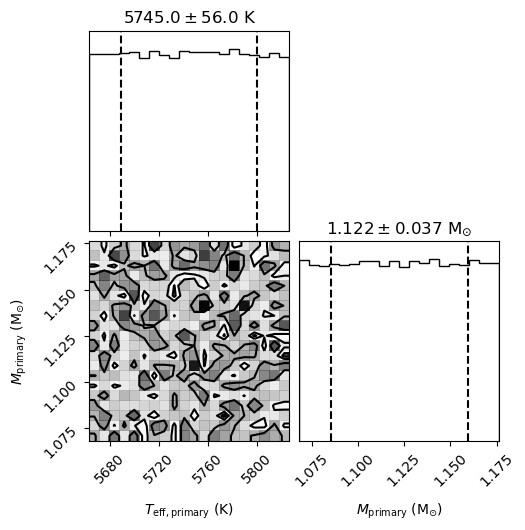

In [13]:
# Poro et al. (2021) [Investigation of P_orb and other params relationships]
# using uninformative uniform priors; mainly looking to restrict optimizer parameter space
p_orb = b.get_value(qualifier='period', component='binary')

# primary T_eff
upperTeffPrimary = (6951.42 + 112.16)*p_orb + (3426.01 + 44.12)
lowerTeffPrimary = (6951.42 - 112.68)*p_orb + (3426.01 - 43.90)

# primary mass
upperMassPrimary = (2.924 + 0.075)*p_orb + (0.147 + 0.029)
lowerMassPrimary = (2.924 - 0.075)*p_orb + (0.147 - 0.029)

b.add_distribution({
	'teff@primary': phoebe.uniform(high=upperTeffPrimary, low=lowerTeffPrimary, unit=u.K),
	'mass@primary': phoebe.uniform(high=upperMassPrimary, low=lowerMassPrimary, unit=u.solMass)
}, distribution='poro_porb_bounds', overwrite_all=True)

_ = b.plot_distribution_collection(distribution='poro_porb_bounds', show=True)

## Save bundle

In [14]:
# gen_utils.saveBundle(b, "iturbide_gaia-data")
# gen_utils.saveBundle(b, "iturbide_gaia-data", "aviles-data")
# gen_utils.saveBundle(b, "iturbide_gaia-data", "comp-LID-3")
# gen_utils.saveBundle(b, bundleName="iturbide-gaia-ztf")
# gen_utils.saveBundle(b, bundleName="iturbide-gaia-ztf", subfolder="ltt-corrected")
gen_utils.saveBundle(b, bundleName="iturbide-gaia-ztf", subfolder="relative-normalized")

# next: run periodogram

'bundle-saves/relative-normalized/iturbide-gaia-ztf'